# Text Analysis With Twitter Data

So far in this tutorial series we've discussed at length how to clean and process Twitter data. We've also introduced aspects of Natural Language Processing (NLP) such as word clouds and counting statistics. In this notebook, we will construct a topic model using **word vectors**, **word embeddings** and **K-means**. You will discover how to identify the topics that you're interested in analyzing. This model will have applications in the identification of groups of users for targeted advertising, or as a tool to quickly find relevant tweets to help quantify potential demand for a product/service. 



## Goals
1. Turn our tweets into "tweet" embeddings. 
2. Cluster those vectors to define topics.
3. Use this model to locate relevant topics and discuss how such a model may be used for market research or advertising.

## Important Note

This analysis considers only tweets which were sent with location from Alberta, so things that "trend" in this data set may be different from things that trend on Twitter proper. **We are also missing tweets which did not have a location tag.**

More importantly - the analysis below is strongest when considering topics that don't yield well to key words. For example, political themes, food, and sports tend to work well with the following analysis as the language surrounding those ideas is _variable_ enough that a key word search may not work, but _consistent_ enough that the language used to describe those things is similar. Where this analysis _will not_ perform well is in cases where a keyword search would be best. For example, if you're looking for tweets concerning shoes, a keyword of shoes/brands will work better than the analysis we're about to do. If you're searching for something more abstract like fashion, the analysis we will walk through in this notebook may perform better than a simple keywords search. 


# Preliminaries 
 In this first section, we have two main concepts to cover: Word vectors and word embeddings. The introduction into k-means clustering will be saved for the relevant section.
 
## TL;DR

Click the drop downs below to get a rather lengthy introduction to word embeddings. We recommend you read at least the introductory sections for some valuable context, but, if you want to get started here is a three point summary:

1. By using a simple neural net, it is possible to map a word to a unique 300 dimensional vector. This vector is known as a word embedding.
2. Sentences can be represented as linear sums of the word embeddings of each word in the sentence. 
3. Words are similar or different based on the angle between their word embedding vectors. 
 
### Would you like to know more?
<details> 
    <summary> Click here to know more </summary>
<br>



## Word vectors

A word vector is the conversion of a word into a sparse, 'one-hot' vector. Each word contained within the selected tweets is mapped to a unique vector with only a single non-zero element. For example, the word "karate" may appear as 

\begin{equation}
\mbox{Karate} = 
\begin{pmatrix}
0 \\
\vdots \\
1 \\
\vdots \\
0
\end{pmatrix}.
\end{equation}

"Karate" is represented as a _unique_ and _sparse_ vector containing a single non-zero entry. The size of each word vector is $N$, where $N$ is the number of words in our vocabulary. 

## Sentence Vectors

A sentence vector is the word vector representation of sentence or in our case, a tweet. For example, the sentence
``` 
wax on, wax off
```

is just the vector sum of our word vectors for each word, or
\begin{equation}
\vec{D}_1 = 2\vec{w}_1 + \vec{w}_2 + \vec{w_3}.
\end{equation}

Notice how the vector for `wax` was repeated in this particular example. What this tells you is that, in sentence vectors, **punctuation and the order words appear is not important**. The vector representation of a sentence is the same. For example, the sentences

```
Turning words to math? That is lunacy! Why would you do that? 
```
and
```
Turning that math to words is lunacy! Why would you do that?
```

would have an identical _vector_ representation, even though they are different sentences. 


## Word Embeddings 

On their own, word vectors are often too large and sparse to be particularly useful. More importantly, because word vectors are linearly independent (no combination of word vectors can be used to make a different word vector) understanding similarities between words and sentences is impossible. How do we transform these vectors into a form that can be used to understand linguistic similarities? 

What we need to do is develop our word embeddings - a new set of vectors that can relate words and sentences based on their similarities. In this case, we're going to use what's known as a "Neural Embedding", or word embeddings that are a result of a neural network trained on text data. In most applications, a fully connected shallow neural network (a neural network with only a single hidden layer) is used. The resulting parameter weights of the neural network define our _word embeddings_ or,  a series of **dense** vectors that represent the similarities between words. For this example, we will be using a set of pre-trained word embeddings available [in this github repository](https://github.com/eyaler/word2vec-slim/blob/master/GoogleNews-vectors-negative300-SLIM.bin.gz). This is a small version of word embeddings resulting from training on Google News, and has a vocabulary of about 300,000 words. 

Understanding how these word embeddings came about is not necessary. However, for those interested in learning more, you can use the drop-down menus below to find out how the neural network is used to create word embeddings. The first drop-down is very high level, and the next two are quite technical. 

---
<br> 
## Would you like to know more? 
<details>
<summary> Click here to learn about the idea of a word embeddings </summary>
<br>
<h2> Word2Vec Word Embeddings </h2>
 
This section covers the basics of the model known as `word2vec` using what is known as the Continuous Bag Of Words (CBOW) model. In the CBOW model, our task is to predict "missing" words. For example, if we had the sentence 
```
I sure do love learning about word embeddings! 
```

To train our network, we would remove a single word from the sentence above, say "learning". We would then try to predict the word "learning" given an input of the other words in the sentence. Schematically this is represented below: 

![scheme](images/wor2vecschem.png)

We take the input context - the other words in our original sentence, and use them to predict the word that we've removed.  As words can exist in multiple contexts (among different sets of input words), this model can discover how different words are related to each other - with enough data we'll understand the "relationships" between words. What is nice about this model is that we have a massive _labeled_ data set for free!

 This neural network doesn't sound like it's particularly useful - all it is doing is predicting one word based on some words we've given to it as input. We can't even use that outside of the texts we've given it. How is it useful for understanding language? What we're trying to get from the training process is a set of internal parameters that relate our one-hot encoded vector to _all the other_ one-hot encoded vectors. The closer these vectors of internal parameters are, the more similar words are to each other. In the case of word embeddings, the network we use to create them is _only_ useful in terms of the weights it optimizes - not the output it produces.

What this means is that we will have word embeddings that represent the contextual similarities between words. Instead of using our simple one hot encoded vectors, we will now possess a vector formalism that can be used to understand things such as word similarity, and expand those to things like sentence and document similarity. 

---

## Would you like to know more? 
<details>
<summary> Click here to learn more about the neural network and the mathematics </summary>
<br>
<h2> Word2vec neural network and mathematics </h2>

The `word2vec` neural network appears most often as the following schematic

> ![word2vec](images/word2vec.png)
> 
> Image source: https://arxiv.org/pdf/1411.2738.pdf

A brief note on notation: bold quantities will represent both vectors and matrices, however matrices will be capitalized. In the image above, our input layer takes a word vector $\mathbf{x}$, which is the sentence vector with our target word removed (this vector is referred to as the "context"), and $\mathbf{y}$ is the one-hot word encoded vector that we removed from our sentence vector that we're trying to predict. These vectors are both of length $V$, the number of words in our vocabulary. 

We also have $N$ neurons in a hidden layer of $\mathbf{h}$, and two weight matricies $\mathbf{W}$ and $\mathbf{W^\prime}$. Here, $\mathbf{W}$ is a $V \times N$ matrix, and $\mathbf{W^\prime}$ is a $N \times V$ matrix. Notice how the number of hidden neurons defines the size of our hidden parameter matrices. 

## Forward Propagation 

Given the schematic above, we see that the values the hidden layer's output is defined as 
$$
\begin{equation}
\tag{1}
\label{eq:h}
\mathbf{h} = \mathbf{W} \mathbf{x} = \frac{1}{C} \mathbf{W} \cdot \left(\sum_{i=1}^C \mathbf{x}_i \right).
\end{equation}
$$
Where the vector $\mathbf{x}$ in \ref{eq:h} is our sentence vector which is simply the average of all the word vectors that make up the sentence. You may have noticed that in `word2vec` **the hidden layer has no activation function**. 

Now, the next step is to compute the **inputs** to each node on the outer layer, which we will define as $u$. For the $j^{th}$ output node we have
$$
\begin{equation} 
u_j = {\mathbf{v}^\prime_{\mathbf{W}_j}}^T \cdot \mathbf{h} .
\end{equation}
$$
Where ${\mathbf{v}^\prime_{\mathbf{W}_j}}$ is the $j^{th}$ column of the output matrix $\mathbf{W}^\prime$. Finally, we then compute the elements of the output (one-hot encoded) vector $\mathbf{y}$ as a soft-max distribution which can be thought of as the 'activation' function of this network, namely

$$
\begin{equation}
\tag{2}
\label{eq:yi}
y_j  = p(w_{y_j} | w_1, ..., w_C) = \frac{\exp(u_{y_j})}{\sum_{i=1}^V \exp(u_i) }.
\end{equation}
$$

Where the subscript $y_j$ means "the index of the $j^{th}$ output of $\mathbf{y}$. Now we have a definition of our word embeddings, namely:

$$
\begin{equation}
y(\mbox{word}) = \mbox{argmax} \frac{\exp(u_{y_j})}{\sum_{i=1}^V \exp(u_i) } = u_{y_j = index(\mbox{word})} = {\mathbf{v}^\prime_{\mathbf{W}_{j = index(\mbox{word})}}}^T \cdot \mathbf{h} .
\end{equation}
$$

Where we have switched to a more obvious notation, but less clear for derivations.  

As once our neural network is fully trained, we will have $V$ _word embeddings_ of size $N$, the size of our hidden layer. This is because we will now have a mapping from our one-hot encoded output vectors of a specific word to the specific _word embedding_ $u_j$ from equation \ref{eq:yi}. Indeed, the index $j$ where $\mathbf{y}$ is maximal will represent the column of the matrix $\mathbf{u}$ which represents the embedding of the output word $\mathbf{y}$

---

<details>
<summary> Click here to learn about `word2vec back propagation </summary>
<br>
<h2> Finding the weights of the neural network  </h2>



### Learning $\mathbf{W}$ and $\mathbf{W}^\prime$
As the training weights define our word embeddings, it is important to discuss how the randomly initialized weights get updated to effectively represent our word embeddings. 

### Updating $\mathbf{W^\prime}$
As with any neural network, the first step is to define our loss function, in this case we want to maximize the conditional probability (log likelihood) of our output word vector $\mathbf{y}$ given our input context sentence vector $\mathbf{x}$. So, for our first matrix $\mathbf{W^\prime}$ is defined as 
$$
\begin{align}
E & = - \ln p(\mathbf{y_*} | \mathbf{x}) \\
  & = -\ln \left(  \frac{\exp(u_j)}{\sum_{i=1}^V \exp(u_i) }\right) \\
  & = -u_* + \ln \sum_{i=1}^V \exp{u_i} \\
  & = -{\mathbf{v}_{\mathbf{w_O}}}^T \cdot \mathbf{h} + \ln \sum_{i=1}^V \exp({\mathbf{v}_{\mathbf{w}_i}}^T \cdot \mathbf{h}).
\end{align}  
$$
Where the $*$ subscript on $u_*$ is to indicate the index of the actual output word (our target), and $\mathbf{v}_\mathbf{w_O}$ is our output word embedding. Now, let's write out our derivatives explicitly for back propagation. First up,
$$
\begin{align}
\frac{\partial E}{\partial u_j} & = \frac{\partial}{\partial u_j} \left( -u_* + \ln \sum_{i=1}^V \exp{u_i} \right) \\
& = -\delta_{j,*} + \frac{\partial}{\partial u_j}\ln \sum_{i=1}^V \exp{u_i} \\
& = -\delta_{j,*} + \frac{1}{\sum_{i=1}^V \exp{u_i} }  \frac{\partial}{\partial u_j}\sum_{i=1}^V \exp{u_i} \\
& = -\delta_{j,*} + \frac{\exp(u_j)}{\sum_{i=1}^V \exp(u_i) } \\
& = y_i - \delta_{j,*},
\end{align}
$$
where $\delta_{j,*}$ is the Kronecker delta defined as 
$$
\begin{equation}
\delta_{j, *} =
\begin{cases}
        1, &         \text{if } j=*,\\
        0, &         \text{if } j\neq *.
\end{cases}
\end{equation}.
$$

Now that we have the derivative of our loss function with respect to the input to the $j^{th}$ node of our output layer $u_j$, we can also calculate the partial derivative with respect to the output weight $w^\prime_{i,j}$ via the chain rule

\begin{align}
\frac{\partial E}{\partial w^\prime_{i,j}} & =\frac{\partial E}{\partial u_j} \frac{\partial u_j}{\partial w^\prime_{i,j}} \\
& = (y_j - \delta_{j,*} ) \frac{\partial u_j}{\partial w^\prime_{i,j}} \\ 
& = (y_j - \delta_{j,*} ) \cdot \frac{\partial}{\partial w^\prime_{i,j}}\left( {\mathbf{v}^\prime_{\mathbf{W}_j}}^T \cdot \mathbf{h} \right) \\
& = (y_j - \delta_{j,*} ) \cdot \frac{\partial}{\partial w^\prime_{i,j}}\left( \sum_k w_{k,j} h_k \right) \\
& = (y_j - \delta_{j,*} ) \cdot h_i.
\end{align}.=

Fantastic! Now we can define an update equation using gradient decent with learning rate $0 < \eta < 1 $ as

\begin{equation}
w_{i,j}^{\prime (new)} = w_{i,j}^{\prime (old)} - \eta (y_j - \delta_{j,*} ) \cdot h_i,
\end{equation}


or in vector notation 
\begin{equation}
\mathbf{v}_{\mathbf{w}_j}^{\prime(new)} =\mathbf{v}_{\mathbf{w}_j}^{\prime(old)} - \eta (y_j - \delta_{j,*} ) \cdot \mathbf{h}.
\end{equation}

Where recall that $\mathbf{v}_{\mathbf{w}_j}^{\prime}$ is the $j^{th}$ vector of our weight matrix $\mathbf{W}^\prime$

### Updating $\mathbf{W}$

We also have a similar equation for the input weights. Our first derivative will be taken with respect to an arbitrary hidden node $h_i$
$$
\begin{align} 
\frac{\partial E}{\partial h_i} &= \sum_{j=1}^V \frac{\partial E}{\partial u_j} \cdot \frac{\partial u_j}{\partial h_i} \\
& = \sum_{j=1}^V (y_j - \delta_{j, *} )\cdot \frac{\partial}{\partial h_i} \left( \sum_j w^\prime_{i,j} h_j \right) \\
& = \sum_{j=1}^V (y_j - \delta_{j, *}) \cdot w^\prime_{i,j} .
\end{align}
$$
Where the sum is a result of the hidden layer being fully connected. The next derivative is the derivative of our loss function with respect to an arbitrary weight $w_{k,i}$
$$
\begin{align}
\frac{\partial E}{\partial w_{k,i} } & = \frac{\partial E}{\partial h_i} \cdot \frac{\partial h_i}{\partial w_{k,i}} \\
& = \sum_{j=1}^V (y_j - \delta_{j, *} )\cdot w^\prime_{i,j} \cdot \frac{\partial}{\partial w_{k,i}}\left[ \frac{1}{C} \mathbf{W} \cdot \left(\sum_{l=1}^C \mathbf{x}_l \right) \right]\\ 
& = \frac{1}{C} \left( \mathbf{x} \cdot \sum_{j=1}^V (y_j - \delta_{j, *} )\right) \cdot \frac{1}{C} \cdot x_k \\
& \Rightarrow \frac{1}{C} (\mathbf{x} \cdot EH) ,
\end{align}
$$
where 
$$
\begin{equation}
EH = \frac{1}{C} \left( \sum_{j=1}^V (y_j - \delta_{j, *} )\right),
\end{equation}
$$
and $\mathbf{x}$ becomes a vector after summation over $k$. In this case, the final gradient update equation for the input weight is 
$$
\begin{equation}
{\mathbf{v}_{\mathbf{w_{I,c}}}^{\prime}}^{(new)} = {\mathbf{v}_{\mathbf{w_{I,c}}}^{\prime}}^{(old)} - \frac{\eta}{C} EH.
\end{equation}
$$

## Downloading Tweets and Word Embeddings

In the cell below, we're downloading our cleaned tweets once again from the Rapid Access Cloud and putting them into a data frame. We also define our `model`, which is our pre-determined word embeddings that we can use to understand word similarity mathematically. 


In [1]:
import gensim
import urllib.request
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np 
from numpy.linalg import norm

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# download word vectors
model_file = '../data/GoogleNews-vectors-negative300-SLIM.bin'
try:
    model = gensim.models.KeyedVectors.load_word2vec_format(model_file, binary=True)
except:   
     print("Model not found!")

# # download tweets
file = '../data/2020-10-08_start_clean.csv'

# reading 'created_at_date' column as timestamp
df = pd.read_csv(file, parse_dates=['created_at_date'], dtype={'in_reply_to_status_id_str': object}) 

#timezone needs to be converted again
df['created_at_date']=pd.to_datetime(df['created_at_date'],errors='coerce')
df['created_at_date']=df['created_at_date'].dt.tz_convert('MST')

# Cheating in case a tweet is the OG "in reply to" to make the joining easier 
def cheat_join(row):
    if str(row.in_reply_to_status_id_str) == 'nan':
        return row.id_str
    else:
        return row.in_reply_to_status_id_str

df['in_reply_to_statis_id_str'] = df.apply(cheat_join, axis=1)

# Unfortunately, using all the tweets is a little too much for our little ol' server. If you do this workshop
# again locally, feel free to remove this line!
df = df.tail(50000)

## Word Embedding Test Drive

Before we dive into the analysis, let's take a look at these "word embeddings" that we've now discussed at length. In this case, let's look at the embedding for the word "chocolate" 

In [2]:
# Remove the 'len' function and its enclosing parenthesis to look at the vector 
# directly if you're interested 
len(model.wv['chocolate'])

300

What we see here is that the word embedding is a 300 dimensional vector. This means two things:
1. The neural network these embeddings were taken from had a hidden layer of size 300
2. All words that this network was trained on (in this case approximately 300000) have been mapped down do 300 dimensional vectors, rather than their original sparse 300000 dimensional vectors. What a space savings!

Now that we have smaller vectors what can we do with them? As these are now "dense" vectors, we can start to do more exciting vector things with them. For example, we can calculate how "close" these vectors are to each other.  The idea being that the closer two word embeddings are, the more similar in meaning the words they represent are. In this case, vector similarity is calculated using the cosine distance between two vectors $\mathbf{A}$ and $\mathbf{B}$ is defined as 

\begin{equation}
\mbox{similarity} = \frac{\mathbf{A} \cdot \mathbf{B}}{||\mathbf{A}|| ||\mathbf{B}||} = \frac{\mathbf{A} \cdot \mathbf{B}}{\sqrt{\sum_i A_i^2} \sqrt{\sum_i B_i^2} } = \left[-1, 1\right]
\end{equation}

where this is simply the dot product of the normalized vectors. A similarity, often called a cosine distance, can take values between -1 and 1. Values of -1 imply that the vectors are anti-parallel, and in the context of word embeddings these words can be considered to be "opposite". A similarity of 0 implies the vectors are orthogonal, meaning that these words are not similar. Finally, a similarity score of 1 implies they're the same vector, or the same word. **The closer to one the similarity between two word embeddings are, the more similar the words are**.

Let's take that for a spin, first, lets see the most similar words to "chocolate" 

In [3]:
#here we're getting the 10 most similar words to the word "chocolate"
model.most_similar(positive=['chocolate'])

[('chocolates', 0.7569215893745422),
 ('Chocolate', 0.7080809473991394),
 ('caramel', 0.673201322555542),
 ('caramels', 0.6604536175727844),
 ('candy', 0.6375688910484314),
 ('candies', 0.6303936839103699),
 ('nougat', 0.6247628927230835),
 ('macaroons', 0.6229639649391174),
 ('Chocolates', 0.6201929450035095),
 ('choco', 0.612962543964386)]

In the output above, what we see is the word as the first output, and the cosine similarity as the number reported. Feel free to try other words in the above example.

We can also add and subtract these word embeddings to discover how words may be related in more complex ways. For example we can return results like 

> Morning is to breakfast as evening is to ____ 

Where we would fill in the word "dinner" using our human understanding of word play. In terms of vectors, this is done as 

$$ \mathbf{V}(dinner) = \mathbf{V}(breakfast) - \mathbf{V}(morning) + \mathbf{V}(evening) $$


Which can be done using our model below

In [4]:
model.most_similar(positive = ['breakfast','evening'], negative=['morning'])

[('dinner', 0.7749412059783936),
 ('brunch', 0.7472958564758301),
 ('supper', 0.6734399795532227),
 ('dinners', 0.6469027996063232),
 ('meal', 0.6461133360862732),
 ('Dinner', 0.6403424739837646),
 ('Brunch', 0.6256617903709412),
 ('banquet', 0.6239930391311646),
 ('breakfasts', 0.622810423374176),
 ('luncheon', 0.6138026714324951)]

Which, is exciting in the sense that now **anything we can do to a vector, we can now do with language**.

## Try it out 
See if you can add/subtract different combinations of words and discover the resultant word vector. Do the results make sense to you? 

In [5]:
# Enter words as a list like: ["word", "otherword"]
positive = ['winter', 'rain']
negative = ['snow']
model.most_similar(positive = positive, negative=negative)

[('summer', 0.5753494501113892),
 ('spring', 0.5676976442337036),
 ('rains', 0.5368232727050781),
 ('rainless', 0.5075832009315491),
 ('weather', 0.5059000253677368),
 ('springtime', 0.49698516726493835),
 ('summertime', 0.4959694743156433),
 ('winters', 0.49184173345565796),
 ('downpour', 0.4856205880641937),
 ('Unseasonal', 0.4797162711620331)]

In [6]:
thing = df.groupby('in_reply_to_status_id_str').count()
len(thing[thing['created_at_date'] > 1])

985

## Special Note

The word vectors we're using were trained a few years ago, and as such, some words that we use day-to-day now are not included. For example, COVID has no word embedding in our current model. If we want to find Tweets about it, we will need to be a little sneaky when searching for it -- as we will see later 

## Preparing Tweets

Our goal now is to create "tweet" vectors by adding up and averaging all the word vectors in our tweets. Mathematically we're after something of the form 
\begin{equation}
\mathbf{V}_{tweet} = \frac{1}{N}\sum_{word}^N \mathbf{V}_{word}
\end{equation}
where $N$ is the number of words in our tweet. 

But first - we have to do what we always do: clean our tweets even more. The first step, as we've seen before is to remove stop words and turn our tweets into tokens. In this case, the reason we're removing stop words is because they don't add anything "meaningful" to our sentences, and if we keep them in we'll accidentally make tweets look more similar to each other than they are because they're cluttered with filler language! This is done below

In [7]:
import nltk
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')
stop_words.append('amp')
stop_words = set(stop_words)

# Here we need to join our tweets on the if they represent a thread or not 

t = df[['extended_tweet_cleaned', 'in_reply_to_status_id_str']]
twee = t.groupby('in_reply_to_status_id_str')['extended_tweet_cleaned'].apply(lambda x: '     \n'.join(x))
twee=twee.reset_index()
twee = twee.rename(index=str, columns={"extended_tweet_cleaned": "extended_tweet_cleaned_thread"})

df = df.merge(twee, on='in_reply_to_status_id_str', how='left')

def fill_thread(row):
    if str(row['extended_tweet_cleaned_thread']) == 'nan':
        return row['extended_tweet_cleaned'] 
    else:
        return row['extended_tweet_cleaned_thread']

df['extended_tweet_cleaned_thread'] = df.apply(fill_thread, axis = 1)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alextennant/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
# We will only use some of the tweets for time constraints - subsetting will be done later
subset = df.copy()

# tokenization and punctuation removal
def tokenize(row):
    sentence = str(row.extended_tweet_cleaned_thread)
    data_token = gensim.utils.simple_preprocess(sentence,min_len=3)
    tokens = [token for token in data_token if token not in stop_words]
    return tokens

# Now we create a 'lemma' column for our cleaned data!

subset['lemma'] = subset.apply(tokenize, axis=1)

## We are also removing all data where the tweet is less than four words long. 
subset = subset[subset['lemma'].apply(lambda x: len(x) > 3)]

print("Total Tweets to analyze after cleaning: ", len(subset))
subset.head(3)


Total Tweets to analyze after cleaning:  35290


,created_at_date,hashtags_string,user_string,user_location,longitude,latitude,name,screen_name,extended_tweets,extended_tweet_cleaned,in_reply_to_screen_name,in_reply_to_status_id_str,id_str,in_reply_to_statis_id_str,extended_tweet_cleaned_thread,lemma
0,2020-10-25 11:42:34-07:00,,,Toronto ↔️ Niagara,NaN,NaN,Michael Gallo,Galloots,There was a 25% chance of Felix vs Vasek in th...,There was a 25% chance of Felix vs Vasek in th...,NaN,NaN,1320435601108135937,1320435601108135937,There was a 25% chance of Felix vs Vasek in th...,"[chance, felix, vasek, round, sure, enough, ha..."
1,2020-10-25 11:42:47-07:00,,,"Edmonton, Alberta",NaN,NaN,Russell Bird,russellabird,Hard-core carnivore black seasoning on this on...,Hard-core carnivore black seasoning on this on...,NaN,NaN,1320435655525212160,1320435655525212160,Hard-core carnivore black seasoning on this on...,"[hard, core, carnivore, black, seasoning, one,..."
2,2020-10-25 11:42:52-07:00,,,"BC, Canada",NaN,NaN,🇨🇦Courtney Heard (Godless Mom),godless_mom,Thank Thor! every time I’m in LA I end up sobb...,Thank Thor! every time I’m in LA I end up sobb...,NaN,NaN,1320435678182658049,1320435678182658049,Thank Thor! every time I’m in LA I end up sobb...,"[thank, thor, every, time, end, sobbing, wheel..."


## Exercise: Finding Tweet Embeddings

In order to create a topic model, we need to use our `gensim` word vectors to convert our word tokens (`subset['lemma']`) into a tweet embedding. Remember that the formula for tweet vectors is 

\begin{equation}
\mathbf{V}_{tweet} = \frac{1}{N}\sum_{word}^N \mathbf{V}_{word}
\end{equation}

where $N$ is the number of words in the tweet, $\mathbf{V}_{tweet}$ is our **normalized** Tweet embeddings, and $\mathbf{V}_{word}$. 

**Note** to normalize a vector using `numpy`, we can do the following

```python
normalized_tweet_embedding = tweet_embedding/np.linalg.norm(tweet_embedding)
```

Please finish the function below in order to create word embeddings 

In [10]:

# Here we are making a list of all the words we have embeddings for. If a word doesn't have an embedding, 
# we will have to skip it!
vocab = model.vocab.keys()

# Remember, to get a word embedding we can use
# embedding = model['word']

def tweet_vectorizer(tweet):
    vector = np.array([0 for i in range(300)])
    N = 0
    # Here we build our tweet vectors 
    for word in tweet:
        if word in vocab:
            N += 1
            vector =  # YOUR CODE HERE 
    if len(tweet) != 0:
 
        # Average all your tweets into a single "tweet emedding"
        
        vector =# YOUR CODE HERE
        
        # Normalize your tweet embedding
        
        vector =  # YOUR CODE HERE
        
        return list(vector)
    else:
        # If no words in the tweet are in the model, we set it to zero
        # to ensure it will be orthogonal to all other word embeddings. 
        return [0 for i in range(300)]



In [11]:
# Actually call the function 
subset['vect'] = subset['lemma'].apply(tweet_vectorizer)
subset = subset.reset_index(drop=True)
subset.tail(2)


,created_at_date,hashtags_string,user_string,user_location,longitude,latitude,name,screen_name,extended_tweets,extended_tweet_cleaned,in_reply_to_screen_name,in_reply_to_status_id_str,id_str,in_reply_to_statis_id_str,extended_tweet_cleaned_thread,lemma,vect
35288,2020-10-31 16:59:37-07:00,,DwayneMihalicz EppingJohn RadicalRoadBrew,"Rumsey, Alberta",NaN,NaN,John🚜,KowalchukFarms,@DwayneMihalicz @EppingJohn @RadicalRoadBrew O...,Okotoks. It’s a mixed doubles bonspiel,DwayneMihalicz,1322689172298084352,1322689716072841217,1322689172298084352,Okotoks. It’s a mixed doubles bonspiel,"[okotoks, mixed, doubles, bonspiel]","[-0.09447507330941769, -0.05591846778892041, -..."
35289,2020-10-31 16:59:55-07:00,,,NaN,47.769286,-122.530906,Cameron Reister,reister_c,"For Halloween today, I dressed up like the gol...","For Halloween today, I dressed up like the gol...",NaN,NaN,1322689794078638080,1322689794078638080,"For Halloween today, I dressed up like the gol...","[halloween, today, dressed, like, golfer, clea...","[0.024895813391295374, 0.03324168287174965, -0..."


### Potential Solution
<details> 
    <summary> Stuck? Click the drop down to reveal one potential solution. </summary>
<br>



```python
def tweet_vectorizer(tweet):
    vector = np.array([0 for i in range(300)])
    N = 0
    # Here we build our tweet vectors 
    for w in tweet:
        if w in vocab:
            N += 1
            vector = vector + np.array(model[w]) 
    if len(tweet) != 0:
        # Divide by the norm here so we can be lazy with a matrix multiplication later. 
        vector = vector / N
        vector = vector/np.linalg.norm(vector)
        return list(vector)
    else:
        # If no words in the tweet are in the model, we set it to zero
        # to ensure it will be orthogonal to all other word embeddings. 
        return [0 for i in range(300)]
```

## Exercise: Finding Similar Tweets 

We've now created our own "tweet" vectors using our pre-trained model, let's take a look and see how well it worked! First, try out the code below. You will have to write a little code first however! But, note in the cell below that the matrix $\mathbf{A}$ is defined as 

\begin{equation}
A = 
\begin{pmatrix}
\begin{bmatrix}
& & V_{\mbox{tweet } 1} & & & 
\end{bmatrix} \\
 \begin{matrix}
 & & \dots & & & 
\end{matrix} \\
 \begin{matrix}
 & & \dots & & & 
\end{matrix} \\
\begin{bmatrix}
& & V_{\mbox{tweet } N} & & & 
\end{bmatrix}
\end{pmatrix},
\end{equation}


 which is the matrix of all our tweet vectors, where each row is an individual tweet vector. Keep in mind we've also **already normalized all our tweet vectors**. So you don't have to worry about normalizing things again when you're calculating your similarity scores. 



In [12]:
# Create the matrix A
A = np.array(subset['vect'].tolist())
# If any entries are not a number NaN - convert them to zero
A[np.isnan(A)] = 0
print(A.shape)

(35290, 300)


Remember that word embedding similarity is defined to be
\begin{equation}
\mbox{similarity} = \frac{\mathbf{A} \cdot \mathbf{B}}{||\mathbf{A}|| ||\mathbf{B}||} = \frac{\mathbf{A} \cdot \mathbf{B}}{\sqrt{\sum_i A_i^2} \sqrt{\sum_i B_i^2} } = \left[-1, 1\right]
\end{equation}

Where $\mathbf{A}$ and $\mathbf{B}$ are two separate word embeddings.

In our case, because we have already normalized our embeddings, we can simplify this equation to

\begin{equation}
\mbox{similarity} = \mathbf{A} \cdot \mathbf{B}
\end{equation}

#### Hint
In python, matrix multiplication is done with the `@` symbol. For example, the matrix multiplication $\mathbf{A \cdot x} = \mathbf{b}$ would be written in python as
```python
b = A @ x
```



In [13]:

# index of the tweet we're interested in, feel free to change this. 
# Note, your index must be < 70706
interest = 0

# this is the tweet vector at the index we've decided to use 
x = np.array(subset['vect'].iloc[interest])


similarity_scores = # YOUR CODE HERE

# This will find the top 5 highest similarites, then sort them bin descending order 
max_index = similarity_scores.argsort()[-5:][::-1]

# if you're interested in the _least_ similar tweets, try changing things with this
# min_index = np.argpartition(similarity_scores, 5)[:5]


print("="*90)
print("Note: The first most similar tweet will be the tweet itself")
print("Tweet we're looking for similarities to:\n\n",subset['extended_tweet_cleaned'].iloc[interest])
print("="*90)
print()
for index in max_index:
    print(subset['extended_tweet_cleaned'].iloc[index],"||" ,"index =", index,  "similarity score=", similarity_scores[index])
    print()
    

SyntaxError: invalid syntax (<ipython-input-13-cb04494da1c0>, line 10)

Feel free to search for different tweets which are similar. There will be some cases where it works quite well, and some cases where... well it probably didn't do the best job. Unfortunately, that's just the nature of twitter - this model can't account for things like spelling mistakes, emojis, and the typical non-sense that one might expect from within 20000 tweets. But, there will certainly be cases where you may be surprised at how well this method works from nothing but a simple matrix-vector dot product!


# K-means clustering as a topic model

As our tweets are now vectors, we are able to do "vector things" with them. One such "vector thing" is the ability to cluster vectors together based on similarity. We can group similar vectors together and create multiple groups of similar vectors, in our case, tweets which contain similar language. Each of these groups may represent a topic, and we can use these topics to better understand what people are discussing in the tweets - and if we can use that to better understand something of interest to us. 

## K-means

K-means is an algorithm which groups similar vectors (data) around $k$ centers, where the number of centers $k$ is determined in advance. Essentially, K-means groups similar tweets together for us. K-means clustering is deceptively simple and can be described as the following iterative steps

1. Initialize by defining $k$ centroids _randomly_. With our tweets, these centroids will be 300 dimensional points.
2. Repeat the following until changes between iterations are minimal
      - Assign each data point (our tweet vectors) to the centroid to which it is closest. 
      - Recalculate the positions of the centers based on the mean of the data points that were assigned to it.
    
If you're interested in learning more about K-means clustering, expand the drop down below, however an intimate understanding of the algorithm is not required to complete the rest of this tutorial.

---
<details>
<summary> Click here to learn more about the k-means algorithm </summary>
<br>

## The K-means clustering algorithm
In this case, we define a set of centers 
\begin{equation}
means =\left\{\mu_i\right\} |_{i=0}^k 
\end{equation} 
where $k>1$, the number of centers you'd like to look for (and in our case, the number of topics). 

Once we've decided on the number of topics, the objective of k-means is to find 

\begin{equation}
\tag{3}
\label{eq:kmean}
f(\mathbf{\mu};\mathbf{x}) =\min \sum_{j \in k} \sum_{i \in S_j} ||x_i - \mu_j||^2
\end{equation}

where the sets $S_j$ are the sets of points which are closest to center $\mu_j$. In order to find the appropriate means $\mu_j$ an iterative procedure is used. Specifically, we have the following algorithm. 

---
**initialize** $\mu_1, ..., \mu_k \rightarrow$ our randomly chosen centers <br>

**While** objective function \ref{eq:kmean} improves **do**<br>
&nbsp;&nbsp;&nbsp;&nbsp; **Assign** each $\mathbf{x}_i$ to a set $S_1,.., S_k$ based on euclidean distance from each center $\mu_j$: <br>
  &nbsp;&nbsp;&nbsp;&nbsp; **for** $i$ **in range(N)** $\leftarrow$ $N =$Number of data points <br>
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $j =  \mbox{argmin} ||x_i - \mu_k||^2$ <br>
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; add $\mathbf{x}_j$ to $S_j$ <br>
  &nbsp;&nbsp;&nbsp;&nbsp; **end for** <br>
  &nbsp;&nbsp;&nbsp;&nbsp; **for** $j = 1,...,k$: <br>
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\mu_j$ =$ \frac{1}{\mbox{len}(S_j)}\sum_{i \in S_j} x_i$ $\leftarrow$ calculate new centers<br>
  &nbsp;&nbsp;&nbsp;&nbsp;**end for** <br>
**end while**
 


Once that algorithm has converged, we will have a set of $k$ means, and each data point will be assigned to the mean that it is closest. 
    
    
    





## Choosing $k$, the number of clusters/topics

As the number of clusters $k$ is required for our algorithm, how do we decide on how many clusters we should have? Well, this is a case where Data Science becomes more art than science. In this case, we will opt for an "elbow plot", or a plot where we calculate a metric for how well our topic model performs, and the "ideal" number of topics is where further iterations of the model stop improving. This is done in the cell block below. However, it can take a moment to run, so it is currently commented out. **If you'd like to generate your own figure, certainly feel free but note it may take 15-20 minutes to calculate.**

In [28]:
# from IPython.display import clear_output
# from sklearn.cluster import MiniBatchKMeans
# inert = []
# for i in range(2,200):
#     clear_output(wait=True)
#     print(i)
#     # here we're simply calculating more clusters each iteration. 
#     intertia_test = MiniBatchKMeans(init='k-means++',
#                                     n_clusters=i+1, 
#                                     random_state=5, 
#                                     init_size=3*i, 
#                                     batch_size=1000)
#     # This is where we fit our data to our k-means topics 
#     intertia_test.fit(A)
#     # We also save what's known as the model inertia - which is related to how far away each data point 
#     # is from a given topic. A smaller inertia indicates a "better" model. 
#     inert.append(intertia_test.inertia_)

# plt.figure(figsize=(12,8))   
# plt.xlabel("Number of clusters", size = 16)
# plt.ylabel("Momentum (smaller is better)", size=16)
# plt.plot(inert)
# plt.show()


If you run the code cell above, you should get a plot which looks like the one below 

> ![elbow plot](images/momentum.png)
> Figure: This figure is the "elbow" plot which will aide us in choosing the best number of topics

From the figure above, we see that the "momentum" of our plot, or the objective function, gets smaller and smaller as we add more and more topics. The "elbow" is at approximately 50 clusters (however, note that is ambiguous), and for many applications, that may be the number of topics you wish to choose. We however, will choose our maximum of 200 for the following demonstraints as we have many thousands of tweets over about three weeks, and it is likely Twitter was talking about more than 50 things. This is done below, however, feel free to experiment with the `n_clusters` parameter in the cell below and experiment with different topic models. Each model typically only takes a second or two to complete. 

**Note: Feel free to choose a different number of clusters to find a different number of topics**

In [17]:

from sklearn.cluster import MiniBatchKMeans
# Define the k-means model

# Experiment with other topic numbers! Change the number of clusters to anything between 2 and 500 
# ( you could choose more than 500, but it may take a long time to compute!)
clusters = 100
kmeans_model = MiniBatchKMeans(init='k-means++',
                                    n_clusters=clusters, 
                                    random_state=5, 
                                    init_size=5*clusters, 
                                    batch_size=1000)
# Pass it the matrix A, or all out tweets!
kmeans_model.fit(A)
cluster_labels  = kmeans_model.labels_
print("k-means clustering complete!")


k-means clustering complete!


## Testing The Topic Model 

Now that we've created a topic model, it might be nice to test how well it did! In this case, let's see how k-means clustered tweets from an obvious source. We're lucky in that there is a twitter account `@311Calgary` which tweets out road reports, dead animal pick ups, traffic light fixes and so forth. The idea here however is that many of these tweets are very formulaic, and if our topic model performed admirably, these tweets should be clustered well. 

In [18]:
# grab the index of 311calgary tweets 

def tweet_topic_finder(username, df, cluster_labels, set_=True):
    user_tweets =df[df.screen_name == username].index.tolist()
    places=[]
    for labels in user_tweets:
        # Here cluster_labels[labels] returns the topic that each tweet has been assigned to 
        places.append(cluster_labels[labels])
    # set removes duplicates
    if set_:
        return list(set(places))
    else:
        return places

tweet_topic_finder('311calgary', subset, cluster_labels)

[96, 97, 66, 65, 4, 8, 75, 11, 48, 16, 51, 23, 57, 30]

The numbers above are all the topics where the tweets from `@311calgary` got placed by k-means. Explore each topic and see how well you think our model did. Some topics (such as 8, the default below) seem to be very well sorted. However, as you explore see if you can find some exceptions. See if you can understand _why_ something may have been grouped "incorrectly". 

In [20]:
# Change cluster_labels == NUM to view different topics 
itemindex = np.where(cluster_labels ==97)[0]
itemindex
c=0
for i in itemindex:
    c +=1 
    print(subset['extended_tweet_cleaned'].iloc[i])
    print()
print(c)


Opened Traffic or Pedestrian Light Repair request via iphone at 309 14 Av SE  

Opened Traffic or Pedestrian Light Repair request via android at 12 Skyview Ranch Rd NE  One wb green light is not working.

Closed Traffic or Pedestrian Light Repair request at 309 14 Av SE  

Closed Traffic or Pedestrian Light Repair request at 256 Fish Creek Bv SW 

Closed Traffic or Pedestrian Light Repair request at 706 Deerfoot Tr SE 

Closed Traffic or Pedestrian Light Repair request at 12 Skyview Ranch Rd NE 

Opened Traffic or Pedestrian Light Repair request via iphone at 400 Beddington Tr NE  Ped countdown out, sec sb signal red door open.

Opened Traffic or Pedestrian Light Repair request via iphone at 310 Macleod Tr SE  Don't walk out. s.w. cnr. 

Opened Traffic Signal - Timing Inquiry request via iphone at 4920 68 St SE  Lights not changing.

Closed Traffic or Pedestrian Light Repair request at 400 Beddington Tr NE 

Opened Traffic or Pedestrian Light Repair request via iphone at 5796 11 St NE 

However, if you view the topics that our 311 Calgary tweets got placed into - you'll notice that different kinds of reports got placed in their own topic automatically such as closed streetlight requests  and traffic signal timing inquiries . This was all done automatically - we did nothing to ensure that this happened.

# Finding Topics You Care About

You've probably noticed that we just have a bunch of numbers representing topics - we still have no idea what those topics actually are! Unfortunately, that's not something we can get away from. In any form of clustering it is still up to us, humans, to decide what the topic is. We can "cheat" a little and add data to our data set which we feel represents a topic we're interested in, and use that to find a topic we care about.


What we're going to do next is create some "fake" data and see if we can find some topics about food, sports and other things we might be interested in. We're going to insert our own tweets into the data, and re-run the topic model with these new tweets. Then, we'll simply see where our fake tweets ended up!

Remember that we're essentially adding custom word vectors - and the word vectors don't care about things like word order, grammar, or filler words. We essentially just need to do a **keyword search**. Let's take a look at how that's done below.

In [21]:
# Make a new data frame to not mess anything else up 
subset_with_discovery = df.copy()

# here are the sentences we're adding 
# FEEL FREE TO ADD YOUR OWN
sentences = [
    "eat for dinner food lunch",
    "hockey goal win score",
    "sports! winning! boy do I enjoy these atheletes",
    "job openning employment hiring",
    "celebrities oscars award oscar",
    "fashion clothes jewelry design",
    "entertainment social media",
    'movies theatre entertainment art music event',
    'music shows concert',
    'spooky halloween costume',
    'virus new cases lockdown lock down'
]

# Insert a fake user so they're easy to find like the 311calgary tweets 
user = 'fake_tweets_for_analysis'

# Need to fill in the other data to the table, here we're just entering nothing 
empty = [np.nan for i in range(len(sentences))]
add = {
    'created_at_date': empty,
    'hashtags_string':empty,
    'user_string':empty,
    'user_location':empty,
    'longitude':empty,
    'latitude':empty,
    'name':empty,
    'screen_name':[user for i in range(len(sentences))],
    'extended_tweet':empty,
    'extended_tweet_cleaned':[sentences[i] for i in range(len(sentences))],
    'extended_tweet_cleaned_thread':[sentences[i] for i in range(len(sentences))]
}
    
add = pd.DataFrame.from_dict(add)

# We also need to treat this data just like the original data! Nothing new here 

add['lemma'] = add.apply(tokenize, axis=1)

add['vect'] = add['lemma'].apply(tweet_vectorizer)

new_subset = pd.concat([subset, add]).reset_index(drop=True)

print("Total Tweets to analyze after cleaning: ", len(new_subset))
# This is to just look at our inserted fake tweets 
new_subset.tail(5)


Total Tweets to analyze after cleaning:  35301


,created_at_date,hashtags_string,user_string,user_location,longitude,latitude,name,screen_name,extended_tweets,extended_tweet_cleaned,in_reply_to_screen_name,in_reply_to_status_id_str,id_str,in_reply_to_statis_id_str,extended_tweet_cleaned_thread,lemma,vect,extended_tweet
35296,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fake_tweets_for_analysis,NaN,entertainment social media,NaN,NaN,NaN,NaN,entertainment social media,"[entertainment, social, media]","[0.04208923455555899, -0.03517614083314352, -0...",NaN
35297,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fake_tweets_for_analysis,NaN,movies theatre entertainment art music event,NaN,NaN,NaN,NaN,movies theatre entertainment art music event,"[movies, theatre, entertainment, art, music, e...","[0.009989894133839421, -0.038939341491924934, ...",NaN
35298,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fake_tweets_for_analysis,NaN,music shows concert,NaN,NaN,NaN,NaN,music shows concert,"[music, shows, concert]","[0.04789635831975904, -0.02900591301371449, -0...",NaN
35299,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fake_tweets_for_analysis,NaN,spooky halloween costume,NaN,NaN,NaN,NaN,spooky halloween costume,"[spooky, halloween, costume]","[0.0020765504128703815, 0.006638647756530974, ...",NaN
35300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fake_tweets_for_analysis,NaN,virus new cases lockdown lock down,NaN,NaN,NaN,NaN,virus new cases lockdown lock down,"[virus, new, cases, lockdown, lock]","[0.03913017250155504, 0.07404331802653275, 0.0...",NaN


Great! We've created our fake data and inserted it into our set, let's make a new k-means model and see where those ended up! 

In [22]:
# These lines perform another round of k-means clustering, but this time with the new tweets added in in order
# to determine which cluster relates to our topic of interest
A = np.array(new_subset['vect'].tolist())
A[np.isnan(A)] = 0

kmeans_model = MiniBatchKMeans(init='k-means++',
                                    n_clusters=clusters, 
                                    random_state=2, 
                                    init_size=5*clusters, 
                                    batch_size=1000)
kmeans_model.fit(A)
cluster_labels  = kmeans_model.labels_
new_subset['topic'] = cluster_labels.tolist()

Same code as our 311Calgary tweets, lets' see where our nefarious fake tweets have landed in the topic model, and judge for ourselves how well they worked. 

In [23]:
places = tweet_topic_finder(user, new_subset, cluster_labels, set_=False)

tweets_clusters = pd.DataFrame(
    {'Sentence': sentences,
     'Cluster': places
    })

print("Our fake tweets of 'known' topic gave ended up in the following topics:\n", tweets_clusters)


Our fake tweets of 'known' topic gave ended up in the following topics:
                                            Sentence  Cluster
0                         eat for dinner food lunch       41
1                             hockey goal win score       77
2   sports! winning! boy do I enjoy these atheletes       29
3                    job openning employment hiring       31
4                    celebrities oscars award oscar       74
5                    fashion clothes jewelry design       22
6                        entertainment social media       17
7      movies theatre entertainment art music event       17
8                               music shows concert       17
9                          spooky halloween costume       18
10               virus new cases lockdown lock down       86


# Let's look at where our "infiltration" tweets ended up 

Let's start with topic `25`, which is our sports topic and see how well it did. This is done below 

In [24]:
itemindex = np.where(cluster_labels== 18)[0]
itemindex
c=0
for i in itemindex:
    c +=1 
    print(new_subset['extended_tweet_cleaned'].iloc[i])
    print()
print(c)

Sleepovers ⛺️ snowball fights ❄️ ghost pancakes 👻 kinda weekend 💚❤️ Perfection @ Calgary, Alberta 

I’m so excited about my Halloween weekend stream with my pack♥️

6 days till Halloween!!! Celebrate with the spookiest playlist on the block. SpookySzn yyc calgary Halloween2020 halloweenparty 

just me and your ghost Halloween spookyseason GhostAdventures 

Halloween is less than a week away!Don't forget to tag us on instagram and use the hashtag derrickhalloween or send your photos to promotions@derrickclub.com🎃👻🧙🧟🕸️derrickclub halloween yeg golf 

I made you guys a pumpkin 🥺Happy Halloween 🎃       

hi i’m reagan, i’m pan and halloween is my fave holiday spookyLGBTQIA 🎃🕷🕸🩸🦴🔪 

Yay!!! Halloween decorations!! inflatables dragon skeleton vampire myboyfriendlovesme apparentlyawomanlivesherenow yay @ Sherwood Park, Alberta 

Walmart - Edmonton, Alberta - Halloween decorating kit I ate one and got sick after Food Poisoning 

When Dwight Shrute meets the princess 👑💜.....theoffice yeg hallowe

Arguably it did pretty well, certainly not all the tweets are about food, but considering we were able to sort these into 50 topics in a few seconds, it did pretty good!

### For you: Exercise
Try adding your own key word searches into the model and re running it. Do the topics your fake tweets end up in make sense? What do you think you could do to make things a little better? Also try things like a different number of topics - how do your results chance? 

## Next Steps

From here you've got a great baseline to start things like market research. If you find a large group of tweets relevant to you, you can use those to understand how people are discussing those issues publicly. Either from a sentiment analysis to understand how people feel, as market research to understand what people seem to need, or to discover which users to target for advertising purposes. Of course, this is a minimal model and may not be perfect for answering those questions explicitly. However, understanding this model can act as a solid basis to iterate to more complex models which may see greater success in understanding your business problems via twitter text analysis. 

## Epilogue: Finding users in your topic 

Suppose you've found a group of tweets around a topic of interest to you. Suppose for example you're interested in the Halloween topic, which is topics number `83` in our model. We can find these users using some simple `pandas` commands  

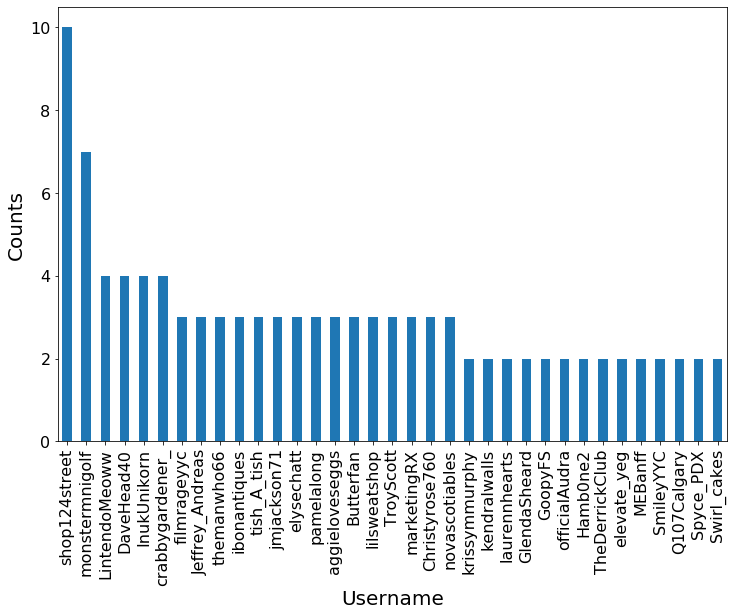

In [25]:
# Filter by topic, where the number in subset.topic == NUMBER is the topic of interest
# Note: the " | " means "Or"

halloween = new_subset[(new_subset.topic == 18)].copy()
# Count how many times each user tweets 
counted = halloween.groupby(['screen_name'])['screen_name'].count().sort_values(ascending=False)

ax = counted[0:35].plot(kind = 'bar', figsize= (12,8))
ax.set_ylabel("Counts", size = 20)
ax.set_xlabel("Username", size = 20)
ax.tick_params(axis='both', which='major', labelsize=16)

Where in the plot above we've only plotted the first 35 users with the most tweets in topic 83, a topic we have decided is a Halloween topic. One caveat to Twitter is when one user has significantly more Tweets in a topic, that usually means one of two things:

1. This user is passionate about the topic their tweets got sorted into
2. This user is a corporate account, and what we're seeing are ads

In this case, let's take a look at `shop124street` to make sure that this is actually a user, and not an obvious ad bot. We view the first five tweets below. 

In [27]:
for tweets in halloween[halloween.screen_name == 'shop124street'].extended_tweet_cleaned.tolist()[0:5]:
    print(tweets)
    print()

Oct 28-31st,  has a Halloween Spooky Sale!💀Promo Code: Spooky10 online or instoresale shop124street 

This Halloween weekend can be a colourful scare 🎃 with this Halloween cake. shop124street

The holidays are coming! Halloween first 🎃Then...🎄

Great job !What is your Halloween costume this year? 👻🎃☠🧟‍♂️

A Halloween classic is watching The Great Pumpkin episode of  by Charles M. SchulzOr get the book at your friendly neighbourhood shop  



Where in this case, it appears `shop124street` is really into Halloween. Of course, this is unsurprising as once you checkout their [Twitter Page](https://twitter.com/shop124street?lang=en), this 124 street in Edmonton, a collection of businesses running some ads for Halloween. Keep in mind, we as the programmer did nothing to influence that he would appear in a topic about Halloween (besides of course, our choices of data cleaning and word embeddings...) . It was all math!

In [ ]:
# Here we're seeing who tweets most in this topic 
s=halloween.groupby(['screen_name'])['screen_name'].count().sort_values(ascending=False)

# This is a potential list of users who we may want to target 
s[s>1].index.to_list()
